In [1]:
!pip install sympy --quiet




In [2]:
%matplotlib inline


In [3]:
from sympy import symbols
from sympy.logic.boolalg import to_cnf, Not, And, Or
from sympy.parsing.sympy_parser import parse_expr
import re

In [4]:
def convert_formula_to_cnf_numbers(formula_str):

    unique_symbols = sorted(set(re.findall(r'\b[a-zA-Z]\w*\b', formula_str)))
    symbol_to_number = {sym: idx+1 for idx, sym in enumerate(unique_symbols)}

    sympy_symbols = symbols(' '.join(unique_symbols))
    sym_dict = dict(zip(unique_symbols, sympy_symbols))
    parsed_expr = parse_expr(formula_str, local_dict=sym_dict, evaluate=False)
    cnf_expr = to_cnf(parsed_expr, simplify=True)

    def replace_symbols(expr):
        if expr.is_Symbol:
            return symbol_to_number[str(expr)]
        elif isinstance(expr, Not):
            return -replace_symbols(expr.args[0])
        else:
            return expr

    def process_cnf(expr):
        if isinstance(expr, And):
            return [process_cnf(arg) for arg in expr.args]
        elif isinstance(expr, Or):
            return [replace_symbols(arg) for arg in expr.args]
        elif isinstance(expr, Not):
            return [replace_symbols(expr)]
        elif expr.is_Symbol:
            return [replace_symbols(expr)]
        else:
            return [expr]

    cnf_clauses = process_cnf(cnf_expr)

    return cnf_clauses, symbol_to_number


In [5]:
formula = "(a | b) & (~a | c)"
cnf_clauses, mapping = convert_formula_to_cnf_numbers(formula)
print(f"\nOriginal Formula: {formula}")
print(f"CNF (numbers): {cnf_clauses}")
print(f"Mapping: {mapping}")



Original Formula: (a | b) & (~a | c)
CNF (numbers): [[1, 2], [3, -1]]
Mapping: {'a': 1, 'b': 2, 'c': 3}


In [6]:
!pip install qiskit --quiet

from qiskit import QuantumCircuit
from qiskit.circuit.library import MCXGate
from qiskit.visualization import plot_circuit_layout, plot_histogram
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.4 MB/s eta 0:00:00


In [7]:
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=788a025f1f02dc8b180c3b42ca99636e42a1c5ccd07576e62fb801934dd65a92
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


In [8]:
pip install qiskit qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 60.8 MB/s eta 0:00:00


In [9]:
from qiskit.circuit.library import PhaseOracle
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit import transpile
import numpy as np
from collections import defaultdict

def create_numerical_cnf_oracle(num_variables: int, clauses_list: list):
    cnf_parts = []
    for clause in clauses_list:
        literals = []
        for literal in clause:
            var_idx = abs(literal) - 1
            if literal > 0:
                literals.append(f"x{var_idx}")
            else:
                literals.append(f"~x{var_idx}")
        clause_str = "(" + " | ".join(literals) + ")"
        cnf_parts.append(clause_str)
    cnf_expression = " & ".join(cnf_parts)
    print(f"Translated CNF: {cnf_expression}")

    try:
        oracle = PhaseOracle(cnf_expression)
        print("Successfully created oracle from expression.")
        return oracle
    except Exception as e:
        print(f"Error creating oracle: {e}.")
        return None

def check_cnf_classically(assignment_str: str, clauses_list: list[list[int]]) -> bool:
    assignment = [int(bit) for bit in assignment_str]
    for clause in clauses_list:
        clause_satisfied = False
        for literal in clause:
            var_index = abs(literal) - 1
            var_value = assignment[var_index]
            if (literal > 0 and var_value == 1) or (literal < 0 and var_value == 0):
                clause_satisfied = True
                break
        if not clause_satisfied:
            return False
    return True

def find_satisfying_states(oracle, num_variables, clauses_list):
    if not oracle:
        return []

    qc = QuantumCircuit(oracle.num_qubits)
    qc.append(oracle, range(oracle.num_qubits))
    qc.save_unitary()

    simulator = AerSimulator()
    tqc = transpile(qc, simulator)
    result = simulator.run(tqc).result()
    unitary = result.get_unitary()

    phase_groups = defaultdict(list)
    for i in range(2**num_variables):
        val = np.round(unitary.data[i, i], decimals=5)
        phase_groups[val].append(format(i, f'0{num_variables}b'))

    if len(phase_groups) != 2:
        print("Warning: Did not find exactly two distinct phases on the diagonal.")
        return []

    phases = list(phase_groups.keys())
    phase1, phase2 = phases[0], phases[1]

    if not np.isclose(phase1, -phase2):
        print(f"Warning: Phases {phase1} and {phase2} are not opposites.")
        return []

    sample_state = phase_groups[phase1][0]

    if check_cnf_classically(sample_state, clauses_list):
        return phase_groups[phase1]
    else:
        return phase_groups[phase2]

if __name__ == "__main__":
    num_vars_example = 3
    clauses_example = [[1, 2, 3], [-1, -2, 3], [-1, 2, -3], [1, -2, -3]]

    my_numerical_oracle = create_numerical_cnf_oracle(num_vars_example, clauses_example)

    if my_numerical_oracle:
        print("\n oracle properties ")
        print(f"Qubits needed: {my_numerical_oracle.num_qubits} (may include ancillas)")

        satisfying_states = find_satisfying_states(my_numerical_oracle, num_vars_example, clauses_example)

        print("\n satisfying states ")
        if not satisfying_states:
            print("CNF is unsatisfiable.")
        else:
            print(f"Found {len(satisfying_states)} satisfying states:")
            for state in sorted(satisfying_states):
                print(f"  state |{state}> satisfies the CNF.")


Translated CNF: (x0 | x1 | x2) & (~x0 | ~x1 | x2) & (~x0 | x1 | ~x2) & (x0 | ~x1 | ~x2)
Successfully created oracle from expression.

 oracle properties 
Qubits needed: 3 (may include ancillas)


/tmp/ipython-input-3096064065.py:24: DeprecationWarning: The class ``qiskit.circuit.library.phase_oracle.PhaseOracle`` is deprecated as of Qiskit 2.2. It will be removed in Qiskit 3.0. Use the class qiskit.circuit.library.PhaseOracleGate instead.
  oracle = PhaseOracle(cnf_expression)



 satisfying states 
Found 4 satisfying states:
  state |001> satisfies the CNF.
  state |010> satisfies the CNF.
  state |100> satisfies the CNF.
  state |111> satisfies the CNF.


In [10]:
import numpy as np
from qiskit.circuit.library import PhaseOracle
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

def verify_oracle_phase_flip(clauses_list, num_vars, known_solution_str, known_nonsolution_str):
    print("--- Oracle Verification Script ---")

    cnf_expression = " & ".join(
        ["(" + " | ".join(
            [f"x{abs(l)-1}" if l > 0 else f"~x{abs(l)-1}" for l in c]
        ) + ")" for c in clauses_list]
    )
    print(f"Testing CNF: {cnf_expression}")
    oracle = PhaseOracle(cnf_expression)

    qc = QuantumCircuit(oracle.num_qubits)
    qc.append(oracle, range(oracle.num_qubits))
    qc.save_unitary()

    simulator = AerSimulator()
    tqc = transpile(qc, simulator)
    unitary = simulator.run(tqc).result().get_unitary()

    solution_idx = int(known_solution_str, 2)
    nonsolution_idx = int(known_nonsolution_str, 2)

    solution_phase = np.round(unitary.data[solution_idx, solution_idx], decimals=5)
    nonsolution_phase = np.round(unitary.data[nonsolution_idx, nonsolution_idx], decimals=5)

    print(f"\nVerifying state |{known_solution_str}> (a known solution)...")
    print(f"  - Phase on unitary diagonal: {solution_phase}")

    print(f"Verifying state |{known_nonsolution_str}> (a known non-solution)...")
    print(f"  - Phase on unitary diagonal: {nonsolution_phase}")

    is_flipped = np.isclose(solution_phase, -nonsolution_phase)

    print("\n--- Verification Result ---")
    if is_flipped:
        print(" SUCCESS: The oracle correctly flipped the phase of the solution state.")
        return True
    else:
        print(" FAILURE: The oracle did NOT flip the phase of the solution state.")
        return False

if __name__ == "__main__":
    num_variables = 3
    clauses = [[1, -2], [2, -3]]

    solution = "000"
    non_solution = "110"

    verify_oracle_phase_flip(clauses, num_variables, solution, non_solution)


--- Oracle Verification Script ---
Testing CNF: (x0 | ~x1) & (x1 | ~x2)

Verifying state |000> (a known solution)...
  - Phase on unitary diagonal: (-1+0j)
Verifying state |110> (a known non-solution)...
  - Phase on unitary diagonal: (1+0j)

--- Verification Result ---
 SUCCESS: The oracle correctly flipped the phase of the solution state.


/tmp/ipython-input-2799797083.py:15: DeprecationWarning: The class ``qiskit.circuit.library.phase_oracle.PhaseOracle`` is deprecated as of Qiskit 2.2. It will be removed in Qiskit 3.0. Use the class qiskit.circuit.library.PhaseOracleGate instead.
  oracle = PhaseOracle(cnf_expression)


In [11]:
import numpy as np
from qiskit.circuit import QuantumCircuit, Gate

def create_rotations_gate(weights: list) -> Gate:
    num_problem_vars = len(weights)
    qc = QuantumCircuit(num_problem_vars, name="Rot")
    for i in range(num_problem_vars):
        theta = 2.0 * np.arcsin(np.sqrt(weights[i]))
        qc.ry(theta, i)
    rot_gate = qc.to_gate()
    rot_gate.label = "Rot"
    return rot_gate


In [12]:
def create_weighted_grover_operator(num_problem_vars: int, oracle: PhaseOracle, rot_gate: Gate) -> Gate:
    diag_elements = [-1.0] * (2**num_problem_vars)
    diag_elements[0] = 1.0
    zero_reflection = Diagonal(diag_elements)

    zero_reflection_qc = QuantumCircuit(num_problem_vars)
    zero_reflection_qc.append(zero_reflection, range(num_problem_vars))
    zero_reflection_decomposed = zero_reflection_qc.decompose()

    zero_reflection_gate = zero_reflection_decomposed.to_gate()
    zero_reflection_gate.name = "R0"

    diffuser_qc = QuantumCircuit(num_problem_vars, name="Diffuser")
    diffuser_qc.append(rot_gate.inverse(), range(num_problem_vars))
    diffuser_qc.append(zero_reflection_gate, range(num_problem_vars))
    diffuser_qc.append(rot_gate, range(num_problem_vars))
    diffuser_gate = diffuser_qc.to_gate()

    num_total_qubits = oracle.num_qubits
    grover_qc = QuantumCircuit(num_total_qubits, name="GroverOp")

    decomposed_oracle = oracle.decompose()
    oracle_qc = QuantumCircuit(*decomposed_oracle.qregs)
    for inst in decomposed_oracle.data:
        if inst.operation.name != 'barrier':
            oracle_qc.append(inst.operation, inst.qubits)
    oracle_gate = oracle_qc.to_gate()

    grover_qc.append(oracle_gate, range(num_total_qubits))
    grover_qc.append(diffuser_gate, range(num_problem_vars))

    return grover_qc.to_gate()


classical satisfying states: ['001', '010', '100', '111']
unweighted expected models (M): 4
optimal iterations: 4
Translated CNF: (x0 | x1 | x2) & (~x0 | ~x1 | x2) & (~x0 | x1 | ~x2) & (x0 | ~x1 | ~x2)
Successfully created oracle from expression.

 simulation results ---

 annotated raw counts
     000: 11
  001: 296  <-- SOLUTION
  010: 6865  <-- SOLUTION
     011: 25
  100: 188  <-- SOLUTION
     101: 2
     110: 24
  111: 781  <-- SOLUTION


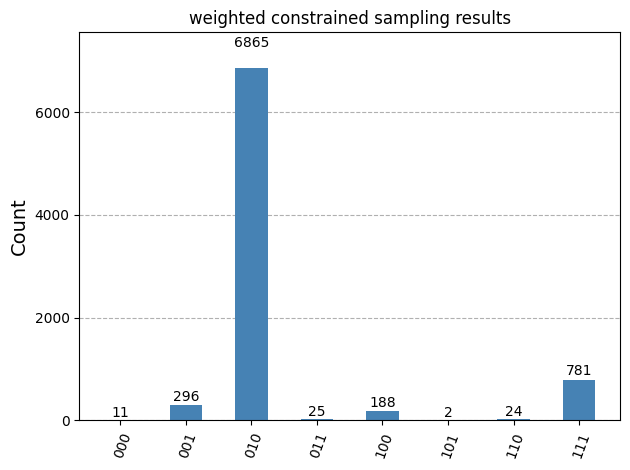

In [13]:
import itertools
import numpy as np
from qiskit import transpile, QuantumRegister, QuantumCircuit, AncillaRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import Diagonal
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

num_vars = 3
clauses = [[1, 2, 3], [-1, -2, 3], [-1, 2, -3], [1, -2, -3]]
weights = [0.2, 0.9, 0.3]

def evaluate_cnf(assignment, clauses):
    for clause in clauses:
        clause_satisfied = False
        for lit in clause:
            var = abs(lit) - 1
            val = assignment[var] if lit > 0 else 1 - assignment[var]
            if val == 1:
                clause_satisfied = True
                break
        if not clause_satisfied:
            return False
    return True

def get_classical_solutions(num_vars, clauses):
    solutions = []
    for i in range(2**num_vars):
        assignment_str = format(i, f'0{num_vars}b')
        assignment_list = [int(bit) for bit in assignment_str]
        if evaluate_cnf(assignment_list, clauses):
            solutions.append(assignment_str)
    return solutions

satisfying_states = get_classical_solutions(num_vars, clauses)
num_solutions = len(satisfying_states)

print(f"classical satisfying states: {satisfying_states}")
print(f"unweighted expected models (M): {num_solutions}")

if num_solutions == 0:
    num_iterations = 0
else:
    num_iterations = 4  # CHNAGE THE NUMBER OF ITERATIONS HERE (IF U WANT U CAN PUT FORMULA HERE TOO (int(np.pi / 4 * np.sqrt(2**num_vars / num_solutions))
print(f"optimal iterations: {num_iterations}")

my_oracle = create_numerical_cnf_oracle(num_vars, clauses)
my_rot_gate = create_rotations_gate(weights)
my_wg_operator = create_weighted_grover_operator(num_vars, my_oracle, my_rot_gate)

problem_qr = QuantumRegister(num_vars, name='problem')
num_ancillas = my_wg_operator.num_qubits - num_vars
classical_cr = ClassicalRegister(num_vars, name='c')

if num_ancillas > 0:
    ancilla_qr = AncillaRegister(num_ancillas, name='ancilla')
    qcs_circuit = QuantumCircuit(problem_qr, ancilla_qr, classical_cr)
else:
    qcs_circuit = QuantumCircuit(problem_qr, classical_cr)

qcs_circuit.append(my_rot_gate, problem_qr)
qcs_circuit.barrier()

if num_iterations > 0:
    for _ in range(num_iterations):
        qcs_circuit.append(my_wg_operator, qcs_circuit.qubits)
        qcs_circuit.barrier()

qcs_circuit.measure(problem_qr, classical_cr)

simulator = AerSimulator()
tqc = transpile(qcs_circuit, simulator)
result = simulator.run(tqc, shots=8192).result()
counts = result.get_counts()

counts_unreversed = {k[::-1]: v for k, v in counts.items()}

print("\n simulation results ---")
print("\n annotated raw counts")
sorted_counts = dict(sorted(counts_unreversed.items()))
for state, count in sorted_counts.items():
    if state in satisfying_states:
        print(f"  {state}: {count}  <-- SOLUTION")
    else:
        print(f"     {state}: {count}")

solution_color = '#5cb85c'
other_color = '#4682b4'
bar_labels = list(counts_unreversed.keys())
color_list = [solution_color if label in satisfying_states else other_color for label in bar_labels]

display(plot_histogram(counts_unreversed, color=color_list, title="weighted constrained sampling results"))





 visualizing the amplification of solutions ---


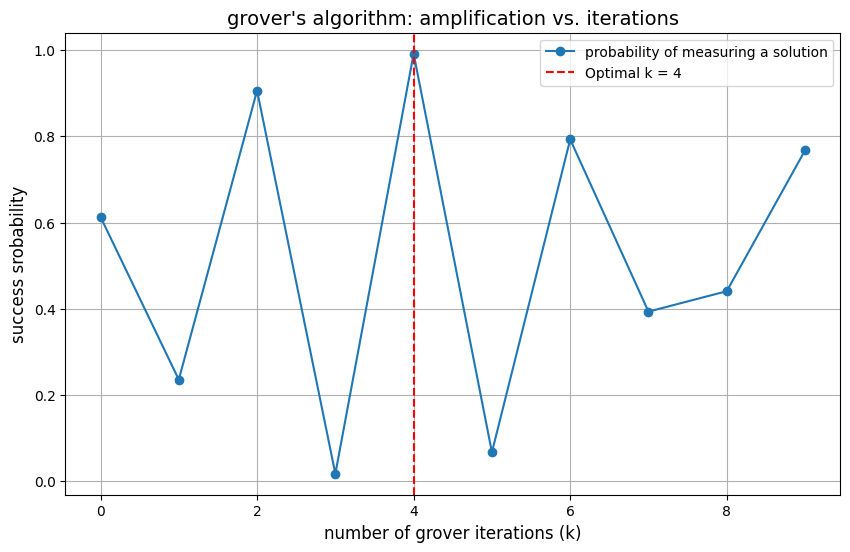

In [14]:
import matplotlib.pyplot as plt
import numpy as np

print("\n visualizing the amplification of solutions ---")

max_iterations = 10
probabilities = []

for k in range(max_iterations):
    num_total_qubits = my_wg_operator.num_qubits
    qc = QuantumCircuit(num_total_qubits, num_vars)
    qc.append(my_rot_gate, range(num_vars))
    for _ in range(k):
        qc.append(my_wg_operator, range(num_total_qubits))
    qc.measure(range(num_vars), range(num_vars))

    tqc = transpile(qc, simulator)
    result = simulator.run(tqc, shots=2048).result()
    counts = result.get_counts()

    total_shots = sum(counts.values())
    success_shots = 0
    for state in satisfying_states:
        reversed_state = state[::-1]
        if reversed_state in counts:
            success_shots += counts[reversed_state]

    success_probability = success_shots / total_shots
    probabilities.append(success_probability)

plt.figure(figsize=(10, 6))
plt.plot(range(max_iterations), probabilities, 'o-', label='probability of measuring a solution')
plt.xlabel("number of grover iterations (k)", fontsize=12)
plt.ylabel("success srobability", fontsize=12)
plt.title("grover's algorithm: amplification vs. iterations", fontsize=14)
plt.axvline(x=num_iterations, color='r', linestyle='--', label=f'Optimal k = {num_iterations}')
plt.grid(True)
plt.legend()
plt.show()



  visualizing initial guess vs final amplified state 


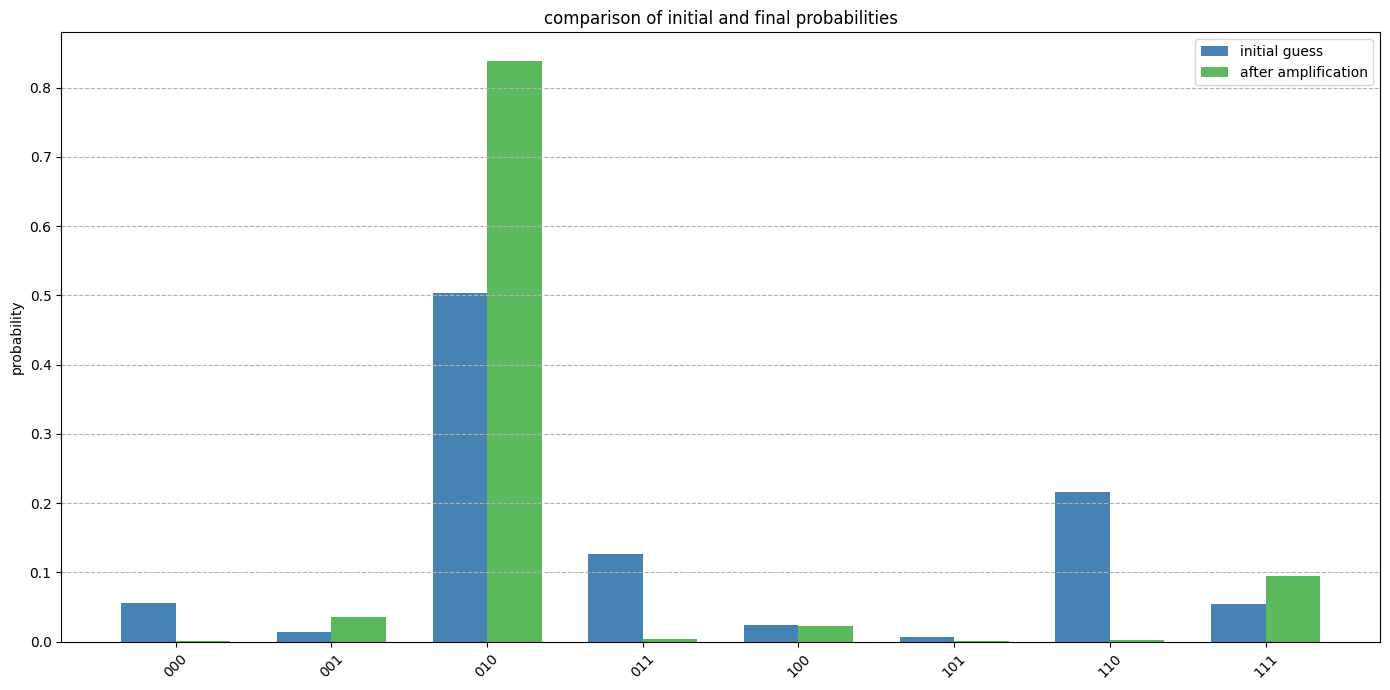

In [15]:
import matplotlib.pyplot as plt
import numpy as np

print("\n  visualizing initial guess vs final amplified state ")

initial_probs = {}
for i in range(2**num_vars):
    state_str = format(i, f'0{num_vars}b')
    prob = 1.0
    for j, bit in enumerate(state_str):
        weight_index = num_vars - 1 - j
        if bit == '1':
            prob *= weights[weight_index]
        else:
            prob *= (1 - weights[weight_index])
    initial_probs[state_str] = prob

total_shots = sum(counts_unreversed.values())
final_probs = {state: count / total_shots for state, count in counts_unreversed.items()}

labels = sorted(initial_probs.keys())
initial_values = [initial_probs[key] for key in labels]
final_values = [final_probs.get(key, 0) for key in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 7))
rects1 = ax.bar(x - width/2, initial_values, width, label='initial guess', color='#4682b4')
rects2 = ax.bar(x + width/2, final_values, width, label='after amplification', color='#5cb85c')

ax.set_ylabel('probability')
ax.set_title('comparison of initial and final probabilities')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
ax.grid(axis='y', linestyle='--')

fig.tight_layout()
plt.show()



 Oracle's Phase Flip 
state before oracle 


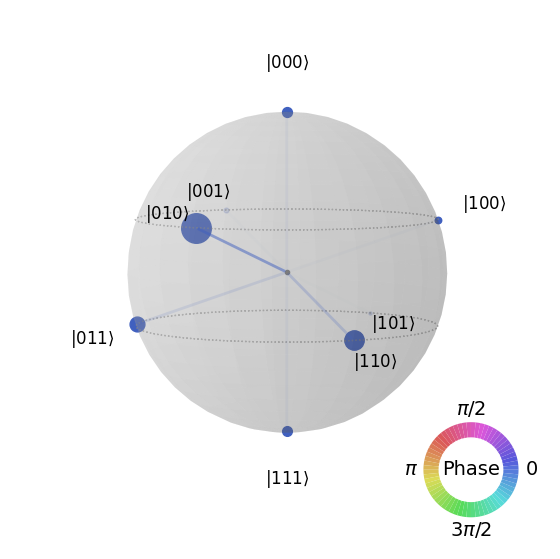


state after oracle 


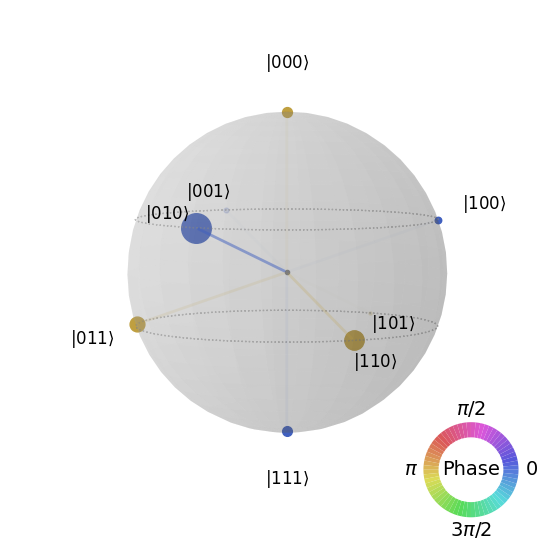

In [16]:
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_qsphere

print("\n Oracle's Phase Flip ")

pre_oracle_circuit = QuantumCircuit(num_vars)
pre_oracle_circuit.append(my_rot_gate, range(num_vars))
sv_pre_oracle = Statevector.from_instruction(pre_oracle_circuit)

post_oracle_circuit = QuantumCircuit(my_oracle.num_qubits)
post_oracle_circuit.append(my_rot_gate, range(num_vars))
post_oracle_circuit.append(my_oracle.to_gate(), range(my_oracle.num_qubits))
sv_post_oracle = Statevector.from_instruction(post_oracle_circuit)

print("state before oracle ")
display(plot_state_qsphere(sv_pre_oracle))

print("\nstate after oracle ")
display(plot_state_qsphere(sv_post_oracle))


state preparation circuit (A operator) 


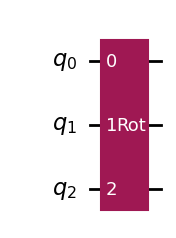


 one weighted grover iteration (g_w operator)


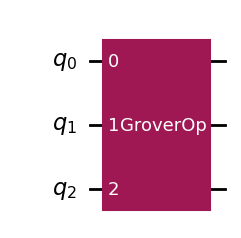

In [17]:
from qiskit.visualization import plot_bloch_multivector
import matplotlib.pyplot as plt

rot_circuit = QuantumCircuit(num_vars)
rot_circuit.append(my_rot_gate, range(num_vars))
print("state preparation circuit (A operator) ")
display(rot_circuit.draw('mpl'))

grover_circuit = QuantumCircuit(my_wg_operator.num_qubits)
grover_circuit.append(my_wg_operator, range(my_wg_operator.num_qubits))
print("\n one weighted grover iteration (g_w operator)")
display(grover_circuit.draw('mpl'))


In [18]:

import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Gate
from qiskit.quantum_info import Operator

num_vars = 3
weights = [0.2, 0.9, 0.3]

def create_rotations_gate(weights: list) -> Gate:
    num_problem_vars = len(weights)
    qc = QuantumCircuit(num_problem_vars, name="Rot")
    for i in range(num_problem_vars):
        theta = 2.0 * np.arcsin(np.sqrt(weights[i]))
        qc.ry(theta, i)
    return qc.to_gate()

def create_buggy_diffuser_gate(num_vars: int, rot_gate: Gate) -> Gate:
    qc = QuantumCircuit(num_vars, name="BuggyDiffuser")
    qc.append(rot_gate.inverse(), range(num_vars))
    qc.x(range(num_vars))
    qc.h(num_vars - 1)
    qc.mcx(list(range(num_vars - 1)), num_vars - 1)
    qc.h(num_vars - 1)
    qc.x(range(num_vars))
    qc.append(rot_gate, range(num_vars))
    return qc.to_gate()

def create_correct_diffuser_gate(num_vars: int, rot_gate: Gate) -> Gate:
    qc = QuantumCircuit(num_vars, name="CorrectDiffuser")
    qc.append(rot_gate.inverse(), range(num_vars))
    if num_vars > 1:
        qc.x(range(num_vars - 1))
    qc.h(num_vars - 1)
    if num_vars > 1:
        qc.mcx(list(range(num_vars - 1)), num_vars - 1)
    else:
        qc.z(0)
    qc.h(num_vars - 1)
    if num_vars > 1:
        qc.x(range(num_vars - 1))
    qc.append(rot_gate, range(num_vars))
    return qc.to_gate()


rotation_gate = create_rotations_gate(weights)
buggy_diffuser_gate = create_buggy_diffuser_gate(num_vars, rotation_gate)
correct_diffuser_gate = create_correct_diffuser_gate(num_vars, rotation_gate)

buggy_op = Operator(buggy_diffuser_gate)
correct_op = Operator(correct_diffuser_gate)

buggy_eigenvals = np.linalg.eigvals(buggy_op.data)
correct_eigenvals = np.linalg.eigvals(correct_op.data)

print("\n eigenvalues of the buggy diffuser ")
print("a correct reflection only have eigenvalues of +1 or -1.")

print(np.round(buggy_eigenvals, 4))

print("\n\n eigenvalues of the correct diffuser ")

print(np.round(correct_eigenvals, 4))



 eigenvalues of the buggy diffuser 
a correct reflection only have eigenvalues of +1 or -1.
[ 1.+0.j -1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j]


 eigenvalues of the correct diffuser 
[ 1.+0.j -1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j]



 building quantum phase estimation circuit ---

 running QWMC simulation 
most frequent measurement: |1011100001>
measured eigenvalue phase (phi_measured): 1.7610

 final results 
 estimated probabilistic WMC: 0.5945
   classical WMC: 0.5960
   estimation error: 0.0015


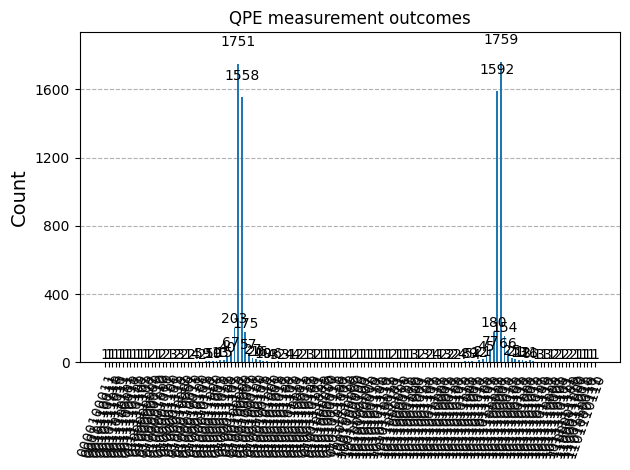

In [19]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit import Gate
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

def qft_dagger(num_qubits: int) -> Gate:
    qc = QuantumCircuit(num_qubits)
    for qubit in range(num_qubits // 2):
        qc.swap(qubit, num_qubits - qubit - 1)
    for j in range(num_qubits):
        for m in range(j):
            qc.cp(-np.pi / (2 ** (j - m)), m, j)
        qc.h(j)
    qft_gate = qc.to_gate()
    qft_gate.name = "QFT†"
    return qft_gate

def build_qpe_circuit(unitary_gate: Gate, num_eval_qubits: int, initial_state_prep: Gate) -> QuantumCircuit:
    n_target = unitary_gate.num_qubits
    n_problem = initial_state_prep.num_qubits
    eval_qr = QuantumRegister(num_eval_qubits, name='eval')
    target_qr = QuantumRegister(n_target, name='target')
    creg = ClassicalRegister(num_eval_qubits, name='c')
    qc = QuantumCircuit(eval_qr, target_qr, creg)
    qc.h(eval_qr)
    qc.append(initial_state_prep, target_qr[:n_problem])
    qc.barrier()
    for i in range(num_eval_qubits):
        power = 2 ** i
        controlled_unitary = unitary_gate.control(1)
        for _ in range(power):
            qc.append(controlled_unitary, [eval_qr[i]] + list(target_qr))
    qc.barrier()
    qc.append(qft_dagger(num_eval_qubits), eval_qr)
    qc.measure(eval_qr, creg)
    return qc

print("\n building quantum phase estimation circuit ---")
num_eval_qubits = 10
pe_circuit = build_qpe_circuit(my_wg_operator, num_eval_qubits, my_rot_gate)

print("\n running QWMC simulation ")
simulator = AerSimulator()
tqc = transpile(pe_circuit, simulator)
result = simulator.run(tqc, shots=8192).result()
counts = result.get_counts()

import itertools

def compute_classical_wmc(num_vars, clauses, weights):
    total_wmc = 0.0
    for i in range(2**num_vars):
        assignment = [int(bit) for bit in format(i, f'0{num_vars}b')]
        is_solution = True
        for clause in clauses:
            clause_ok = any(
                (assignment[abs(lit)-1] if lit > 0 else 1 - assignment[abs(lit)-1])
                for lit in clause
            )
            if not clause_ok:
                is_solution = False
                break
        if is_solution:
            weight = np.prod([
                weights[j] if assignment[j] == 1 else 1 - weights[j]
                for j in range(num_vars)
            ])
            total_wmc += weight
    return total_wmc

top_measurement = max(counts, key=counts.get)
phase_decimal = int(top_measurement, 2) / (2 ** num_eval_qubits)
phi_measured = min(2 * np.pi * phase_decimal, 2 * np.pi * (1 - phase_decimal))
estimated_wmc = np.sin(phi_measured / 2) ** 2

print(f"most frequent measurement: |{top_measurement}>")
print(f"measured eigenvalue phase (phi_measured): {phi_measured:.4f}")
print("\n final results ")
print(f" estimated probabilistic WMC: {estimated_wmc:.4f}")
classical_wmc = compute_classical_wmc(num_vars, clauses, weights)
print(f"   classical WMC: {classical_wmc:.4f}")
print(f"   estimation error: {abs(estimated_wmc - classical_wmc):.4f}")

display(plot_histogram(counts, title="QPE measurement outcomes"))


In [20]:
import numpy as np
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import GroverOperator

print("  running quantum weighted constrained sampling (QWCS) ")

satisfying_states = get_classical_solutions(num_vars, clauses)
num_solutions = len(satisfying_states)
print(f"solutions: {satisfying_states}")

oracle = create_numerical_cnf_oracle(num_vars, clauses)
rotations = create_rotations_gate(weights)

state_prep_circuit = QuantumCircuit(num_vars, name="A")
state_prep_circuit.append(rotations, range(num_vars))
grover_op = GroverOperator(oracle, state_preparation=state_prep_circuit)

num_iterations = 4
print(f"using optimal iterations (determined experimentally): {num_iterations}")

num_total_qubits = grover_op.num_qubits
qc = QuantumCircuit(num_total_qubits, num_vars)
qc.append(state_prep_circuit, range(num_vars))
for _ in range(num_iterations):
    qc.append(grover_op, range(num_total_qubits))
qc.measure(range(num_vars), range(num_vars))

simulator = AerSimulator()
tqc = transpile(qc, simulator)
result = simulator.run(tqc, shots=8192).result()
sampling_counts = result.get_counts()
sampling_counts_unreversed = {k[::-1]: v for k, v in sampling_counts.items()}

print("\n performance evaluation: comparing quantum vs. classical ---")

def get_classical_distribution(num_vars, weights, satisfying_states):
    solution_weights = {}
    total_wmc = 0
    for state in satisfying_states:
        weight = np.prod([weights[j] if bit == '1' else 1 - weights[j] for j, bit in enumerate(state)])
        solution_weights[state] = weight
        total_wmc += weight

    classical_dist = np.zeros(2**num_vars)
    if total_wmc > 0:
        for i in range(2**num_vars):
            state_str = format(i, f'0{num_vars}b')
            if state_str in solution_weights:
                classical_dist[i] = solution_weights[state_str] / total_wmc
    return classical_dist

def get_quantum_distribution(num_vars, counts):
    quantum_dist = np.zeros(2**num_vars)
    total_shots = sum(counts.values())
    if total_shots == 0: return quantum_dist
    for state_str, count in counts.items():
        index = int(state_str, 2)
        quantum_dist[index] = count / total_shots
    return quantum_dist

Q = get_classical_distribution(num_vars, weights, satisfying_states)
P = get_quantum_distribution(num_vars, sampling_counts_unreversed)

epsilon = 1e-9
Q_smooth = Q + epsilon
Q_smooth /= np.sum(Q_smooth)

kl_divergence = entropy(pk=P, qk=Q_smooth)
js_distance = jensenshannon(P, Q, base=2)
js_divergence = js_distance**2
fidelity = np.sum(np.sqrt(P * Q))
cross_entropy_val = -np.sum(P * np.log2(Q_smooth))

print(f"\n{'Metric':<25} {'Value':<15} {'Ideal Value'}")
print("-" * 55)
print(f"{'Fidelity':<25} {fidelity:<15.4f} (Closer to 1 is better)")
print(f"{'KL Divergence':<25} {kl_divergence:<15.4f} (Closer to 0 is better)")
print(f"{'Jensen-Shannon Divergence':<25} {js_divergence:<15.4f} (Closer to 0 is better)")
print(f"{'Cross-Entropy':<25} {cross_entropy_val:<15.4f} (Lower is better)")
print("-" * 55)


  running quantum weighted constrained sampling (QWCS) 
solutions: ['001', '010', '100', '111']
Translated CNF: (x0 | x1 | x2) & (~x0 | ~x1 | x2) & (~x0 | x1 | ~x2) & (x0 | ~x1 | ~x2)
Successfully created oracle from expression.
using optimal iterations (determined experimentally): 4

 performance evaluation: comparing quantum vs. classical ---

Metric                    Value           Ideal Value
-------------------------------------------------------
Fidelity                  0.9958          (Closer to 1 is better)
KL Divergence             0.1155          (Closer to 0 is better)
Jensen-Shannon Divergence 0.0042          (Closer to 0 is better)
Cross-Entropy             1.0683          (Lower is better)
-------------------------------------------------------
